<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Time Series: Rolling Statistics


### Learning Objectives

**After this lesson, you will be able to:**
- Define the concepts of trend and seasonality and be able to identify them visually.
- Use boxplots to compare distributions.
- Plot time series data over time to identify large-scale trends in data.
- Investigate trends by computing simple aggregates with Pandas using the `.resample()` function.
- Compute rolling statistics with Pandas to compare data of a date to a smaller window of time.
- Utilize exponentially weighted windows to average out noise.
- Use differences to remove trends in time series data.
- Use the Pandas' `.shift()` function to create lagged features.

---

### Lesson Guide

#### Time Series Rolling Statistics
- [Trend and Seasonality](#A)
- [Aggregate Data](#B)
- [Rolling Statistics](#C)
- [Differencing a Time Series and Stationarity](#D)
- [Shifting and Lagging Time Series Data](#E)
- [Independent Practice](#F)
----

<h2><a id="A">Trend and Seasonality</a></h2>

**Question:** What constitutes a trend in data? Is linearity required for a trend?

- A trend is any long-term change in the value we're measuring. Trends may “change direction,” going from an increasing trend to a decreasing trend.

- Trends can only be measured within the scope of the data collected; there may be trends that are unmeasurable if the data are not complete.

An example of an upward trend:
![](/assets/images/trend-line2.png)

- When patterns repeat over *known, fixed periods* of time within a data set, we call this **seasonality**.

- A seasonal pattern exists when a series is influenced by factors related to the cyclic nature of time — i.e., time of month, quarter, year, etc. Seasonality is of a fixed and known period, otherwise it is not truly seasonality. Additionally, it must be either attributed to another factor or counted as a set of anomalous events in the data.

>  Can you think of some seasonal patterns from your own experience?


### The easiest way to visualize trends is by drawing trend lines.

In [48]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

# Set global plot parameters
plt.rcParams["figure.figsize"] = [16,9]

# Import the data.
df = pd.read_csv('./mapquest_google_trends.csv')

In [3]:
df.head()

,WeekOf,mapquest
0,2004-01-04,53
1,2004-01-11,53
2,2004-01-18,54
3,2004-01-25,53
4,2004-02-01,52


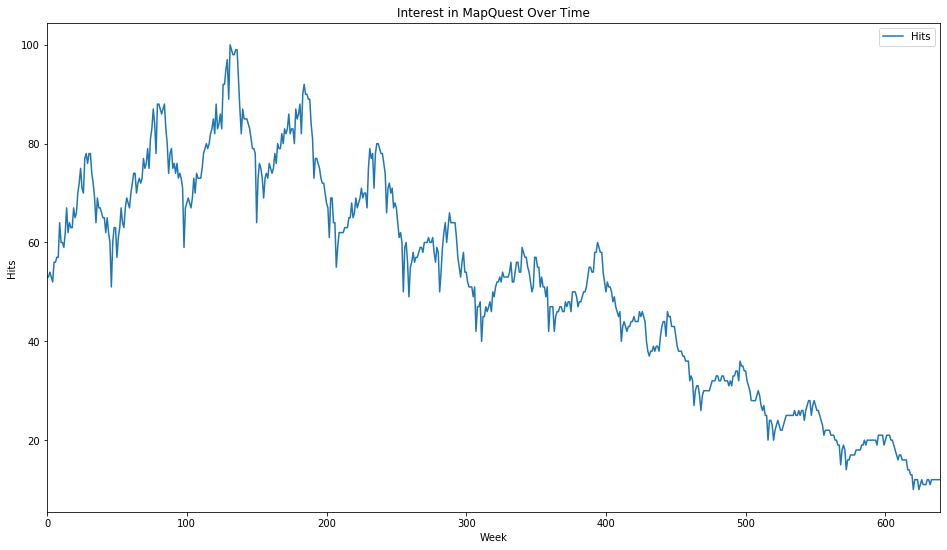

In [4]:
# Clean/organize the data. 
df.columns = ['WeekOf', 'Hits']
ax = df.plot(title = "Interest in MapQuest Over Time");
ax.set_xlabel("Week");
ax.set_ylabel("Hits");

In [5]:
df.head()

,WeekOf,Hits
0,2004-01-04,53
1,2004-01-11,53
2,2004-01-18,54
3,2004-01-25,53
4,2004-02-01,52


In [6]:
df.dtypes

WeekOf    object
Hits       int64
dtype: object

In [16]:
df.index

RangeIndex(start=0, stop=640, step=1)

Next, we need to compute a coefficient and intercept for our line. NumPy's `polyfit()` method can do this.

Then, define our polynomial function using that coefficient. We can do this on a single dimension using NumPy's `poly1d()` method.

In [7]:
line_coef = np.polyfit(df.index, df['Hits'], 1)
print(line_coef)

polynomial = np.poly1d(line_coef)
# The intercept is ~86.59, the slope is ~0.11.

# Let's take a look at the trendline values at specific points:
print(polynomial(0))
print(polynomial(1))

[-0.10841388 86.58979622]
86.58979621684865
86.48138233980062


In [11]:
help(np.polyfit)

Help on function polyfit in module numpy:

polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    Least squares polynomial fit.
    
    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error in the order `deg`, `deg-1`, ... `0`.
    
    The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
    method is recommended for new code as it is more stable numerically. See
    the documentation of the method for more information.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_like, shape (M,) or (M, K)
        y-coordinates of the sample points. Several data sets of sample
        points sharing the same x-coordinates can be fitted at once by
        passing in a 2D-array that contains one dataset per column.
    deg : int
        Degree of the fitting po

### Now, plot our trendline over the data.

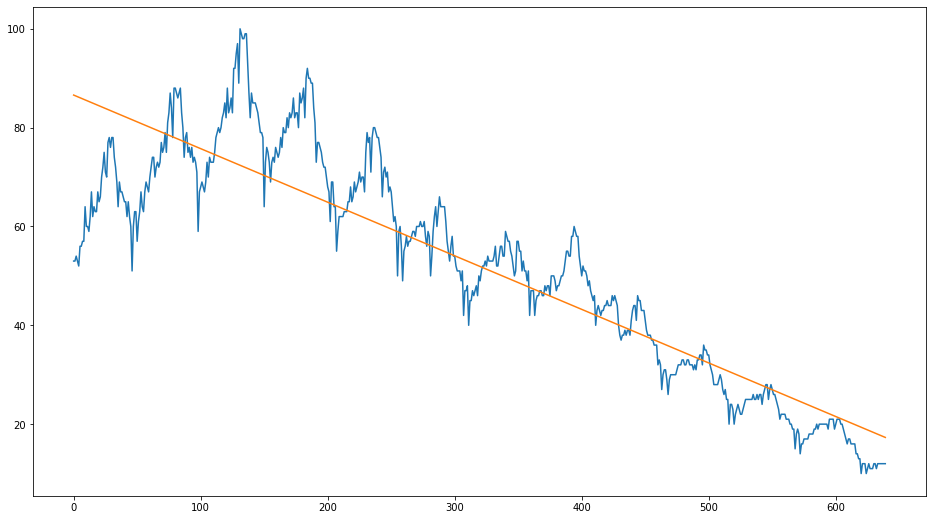

In [8]:
# Plot the time series.
plt.plot(df.index, df['Hits']);

# Plot the least squares minimizing line.
plt.plot(df.index, polynomial(df.index));

Looks like a second-order polynomial might fit our data even better. Let's try that out.

In [9]:
line_coef = np.polyfit(df.index, df['Hits'], 2)
print(line_coef)

second_polynomial = np.poly1d(line_coef)

[-1.84964781e-04  9.77861827e-03  7.40219942e+01]


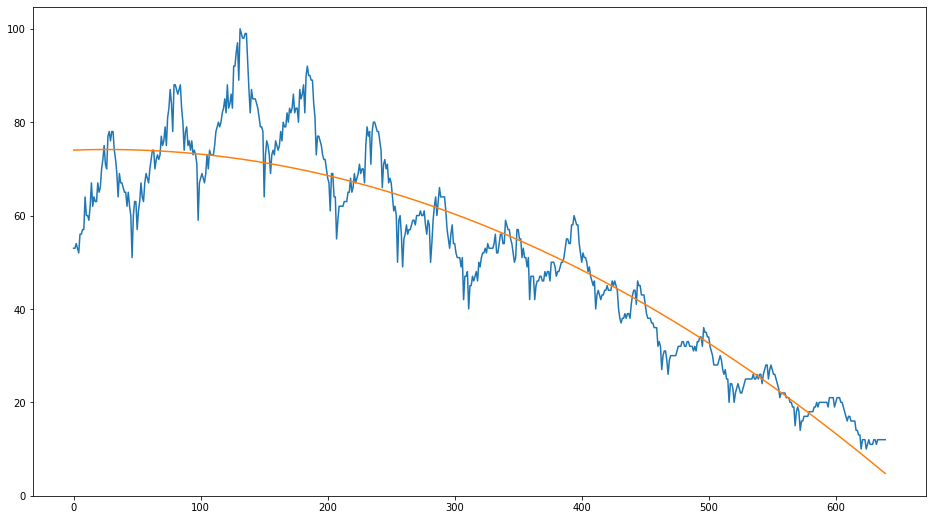

In [10]:
# Plot the time series.
plt.plot(df.index, df['Hits']);

# Plot the least squares minimizing line.
plt.plot(df.index, second_polynomial(df.index));

> **Question:** Can you think of any other underlying patterns that might cause trends in time series data? What might cause seasonality in a time series?

### Guided Practice

Let's look for trends and seasonality in data made available by a German drugstore, Rossmann.

These data contain the daily sales made at the drugstore, as well as whether or not a sale or holiday affected the data.

Because we are most interested in the `Date` column (which contains the date of sales for each store), we will make sure to process that as a `datetime` type and make it the index of our DataFrame, as we did with our Apple stock data. 

Let's recall the steps for preprocessing time series data with Pandas:
* Convert time data to a `datetime` object.
* Set `datetime` to index the DataFrame.

In [11]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('./rossmann.csv', skipinitialspace=True, low_memory=False)

In [12]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [13]:
data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [14]:
# Preprocess data for time series analysis
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [21]:
data.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [15]:
state_holiday = data['StateHoliday'].unique()
state_holiday

array(['0', 'a', 'b', 'c'], dtype=object)

This allows us to easily filter by date. Let's add a column for `Year` and `Month` based on the `datetime` index. 

In [18]:
data['Year'] = data.index.year
data['Month'] = data.index.month

data['2015-05'].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-05-31,1,7,0,0,0,0,0,0,2015,5
2015-05-31,2,7,0,0,0,0,0,0,2015,5
2015-05-31,3,7,0,0,0,0,0,0,2015,5
2015-05-31,4,7,0,0,0,0,0,0,2015,5
2015-05-31,5,7,0,0,0,0,0,0,2015,5


There are more than a million sales data points in this data set, so, for some simple exploratory data analysis (EDA), we'll focus on just one store.

*Note: We explicitly add a `.copy()` to the returned DataFrame because we will be making changes to this DataFrame object later. If we didn't specify this, we will receive SettingCopyWarnings later on because Pandas will not know if we want to edit a view of the original data object (`data`) or a separate data object (`store1_data`). Without the `.copy()`, the variable `store1_data` will simply be a reference the original data object in memory.*

In [19]:
store1_data = data[data['Store'] == 1].copy()
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


In [20]:
store1_data.shape

(942, 10)

### Plot the sales data.

Let's investigate whether or not promotions affect sales. For this, we'll use boxplots.

On state holidays, the store is closed (which means there are zero sales), so we need to cut those days out. (Contextual knowledge like this is always necessary to truly explain time series phenomena.)

> **Check for Understanding:** Can you think of any other special considerations we should make when tracking sales?

Now, check to see if there is a difference affecting sales on promotion days.

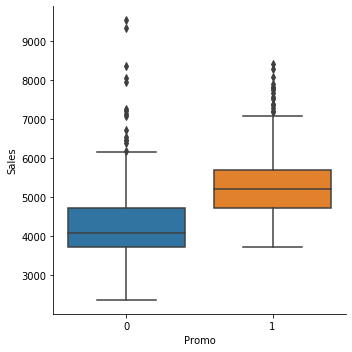

In [28]:
sns.catplot(
    x = 'Promo',
    y = 'Sales',
    data = store1_data[store1_data['Open'] == 1],
    kind = 'box'
);

We can see that there _is_ a difference in sales on promotion days.

Why is it important to separate out days on which the store is closed? Because there aren't any promotions on those days either, so including them will bias our sales data on days without promotions! Remember to think about the business logic in addition to analyzing the raw data.

We may also want to compare sales across days of the week:

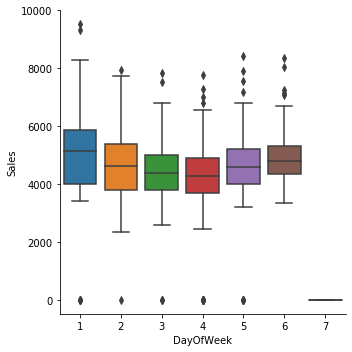

In [21]:
sns.catplot(
    x = 'DayOfWeek',
    y = 'Sales',
    data = store1_data,
    kind = 'box',
);

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

To plot the sales and customer visits over time:

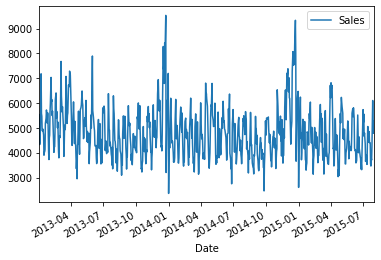

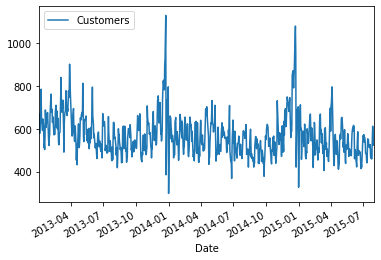

In [22]:
# Filter to days Store 1 was open.
store1_open_data = store1_data[store1_data['Open'] == 1]
store1_open_data[['Sales']].plot();
store1_open_data[['Customers']].plot();

We can see that there are large spikes of sales and customers toward the end of 2013 and 2014, leading into the first quarter of 2014 and 2015.

Let's use index filtering to filter just to 2015 changes over time. This should make it easier to identify the holiday sales bump.


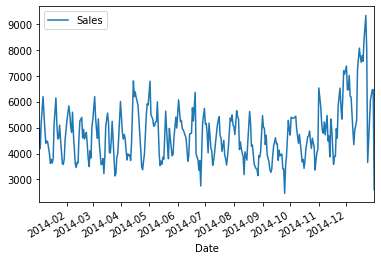

In [25]:
store1_data_2015 = store1_data['2014']
store1_data_2015[store1_data_2015.Open == 1][['Sales']].plot();

<h2><a id= "B">Aggregate Data</a></h2>

If we want to investigate trends over time in sales, as always, we'll start by computing simple aggregates. We want to know: What were the mean and median sales in each month and year?

We can use `data.resample` on the whole data set and provide:
    - A parameter for the level on which to roll up to: `'D'` for day, `'W'` for week, `'M'` for month, `'A'` for year.
    - The aggregation method to perform: `mean()`, `median()`, `sum()`, etc.

In [26]:
data[['Sales']].resample('A').mean()

,Sales
Date,
2013-12-31,5658.533675
2014-12-31,5833.290704
2015-12-31,5878.245380


It looks like average sales were highest in 2015. Now, let's look at the median annual sales.

In [27]:
data[['Sales']].resample('A').median()

,Sales
Date,
2013-12-31,5598
2014-12-31,5794
2015-12-31,5916


In [28]:
data[['Sales']].resample('M').mean()

,Sales
Date,
2013-01-31,5211.555578
2013-02-28,5494.371397
2013-03-31,5820.349168
2013-04-30,5483.749836
2013-05-31,5364.127383
2013-06-30,5402.162960
2013-07-31,6042.062260
2013-08-31,5729.574049
2013-09-30,5322.988430


In [29]:
data[['Sales']].resample('M').median()

,Sales
Date,
2013-01-31,5194.0
2013-02-28,5421.5
2013-03-31,5844.0
2013-04-30,5464.0
2013-05-31,5585.0
2013-06-30,5428.0
2013-07-31,5826.0
2013-08-31,5624.0
2013-09-30,5294.0


For more information, see Pandas' `.resample`  [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html).

<h2><a id = "C">Rolling Statistics</a><h2>

With time series, we can "roll" statistics across time. For example, the rolling mean is the mean of a moving window across time periods. Pandas offers a variety of functionalities for creating rolling statistics, which we'll only scratch the surface of here.

E.g., to understand holidays sales, we don't want to compare sales data in late December with the entire month but instead with a few days immediately surrounding it. We can do this using rolling averages.

The syntax for these can be a little tricky at first. We'll be using a `rolling()` function with a statistical function chained to it. Let's dive into more detail.

### Parameters for `rolling()` Functions

`rolling().mean()` (as well as `rolling().median())` can take the following parameters:

* The first indicates the time series to aggregate.
* `window` indicates the number of periods to include in the average.
* `center` indicates whether the window should be centered on the date or use data prior to that date.


#### Calculate the rolling daily sum over all stores.

Use the `.resample()` function to calculate the daily total over all of the stores.

In [31]:
#daily_store_sales = data[['Sales']].resample('D').sum()
daily_store_sales.head

<bound method NDFrame.head of                Sales
Date                
2013-01-01     97235
2013-01-02   6949829
2013-01-03   6347820
2013-01-04   6638954
2013-01-05   5951593
...              ...
2015-07-27  10707292
2015-07-28   9115073
2015-07-29   8499962
2015-07-30   8798854
2015-07-31  10109742

[942 rows x 1 columns]>

Use the `.rolling()` function to calculate the rolling average over a three-day period.

In [42]:
daily_store_sales.rolling(window=15, center=False).mean()

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
...,...
2015-07-27,6.807855e+06
2015-07-28,6.692775e+06
2015-07-29,6.636746e+06


We can use our index filtering to just look at 2015.

In [44]:
daily_store_sales.rolling(window=7, center=False).mean()['2015']

,Sales
Date,
2015-01-01,3.588075e+06
2015-01-02,4.638959e+06
2015-01-03,4.701819e+06
2015-01-04,4.698837e+06
2015-01-05,5.272034e+06
...,...
2015-07-27,6.110012e+06
2015-07-28,6.504097e+06
2015-07-29,6.845464e+06


Instead of plotting the full time series, we can plot the rolling mean instead, which smooths random changes in sales and removes outliers, helping us identify larger trends.

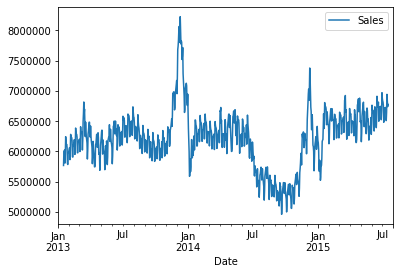

In [45]:
daily_store_sales.rolling(window=30, center=True).mean().plot();

### The Expanding Mean

The expanding mean simply uses all of the data points up to the current time to calculate the mean, as opposed to a moving window.

#### Calculate and plot the expanding mean below. Resample by quarter.

In [46]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=1, center=False).mean()
expanding_mean = data.Sales.resample('Q').sum().expanding().mean()

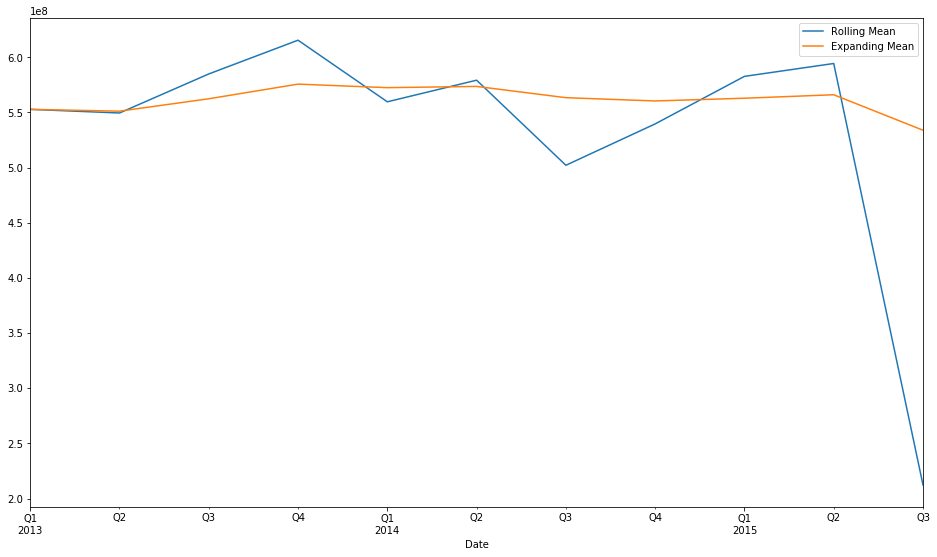

In [49]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
rolling_mean.plot(legend = True);
expanding_mean.plot(legend = True);
ax.legend(['Rolling Mean', 'Expanding Mean']);

In [50]:
data.Sales.resample('Q').sum().rolling(window=1, center=False).mean()

Date
2013-03-31    552846851.0
2013-06-30    549544846.0
2013-09-30    584940572.0
2013-12-31    615543815.0
2014-03-31    559697318.0
2014-06-30    579285285.0
2014-09-30    502157350.0
2014-12-31    539664943.0
2015-03-31    582750871.0
2015-06-30    594426156.0
2015-09-30    212322616.0
Freq: Q-DEC, Name: Sales, dtype: float64

In [51]:
data.Sales.resample('Q').sum().expanding().mean()

Date
2013-03-31    5.528469e+08
2013-06-30    5.511958e+08
2013-09-30    5.624441e+08
2013-12-31    5.757190e+08
2014-03-31    5.725147e+08
2014-06-30    5.736431e+08
2014-09-30    5.634309e+08
2014-12-31    5.604601e+08
2015-03-31    5.629369e+08
2015-06-30    5.660858e+08
2015-09-30    5.339255e+08
Freq: Q-DEC, Name: Sales, dtype: float64

### Exponentially Weighted Windows

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in time series data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of time points that are further in the past.

The (adjusted) exponentially weighted mean for time, $t$, is defined as:

<a id="-xt--fracxt-----alphaxt------alphaxt--------alphatx------alpha-----alpha-------alphat-"></a>
### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

> **Note:** Review Pandas' [documentation](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows) for more information.

**Calculate and plot the exponentially weighted sum along with the rolling sum. What's the difference?**

For example: `.resample('Q').sum().ewm(span=10).mean()`.


In [55]:
rolling_mean = data.Sales.resample('Q').sum().rolling(window=2, center=True).mean()
exp_weighted_mean = data.Sales.resample('Q').sum().ewm(span=10).mean()

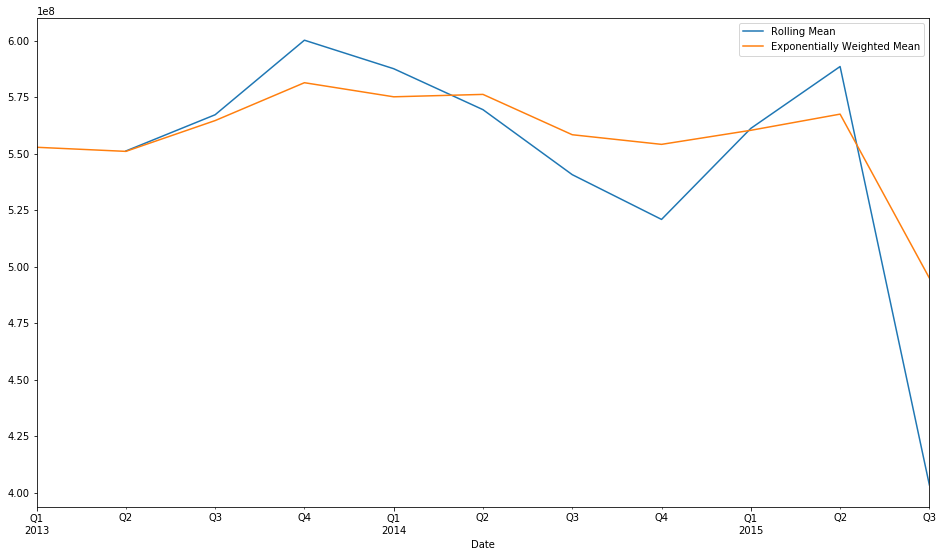

In [56]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
rolling_mean.plot(legend = True);
exp_weighted_mean.plot(legend = True);
ax.legend(['Rolling Mean', 'Exponentially Weighted Mean']);

*Note that rolling doesn't understand if you are missing periods (e.g., if you roll over three days and your data are missing weekends, it'll roll Fri/Sat/Sun), so you need to resample first if you care about that.*

<h2><a id = "D">Differencing a Time Series and Stationarity</a></h2>

If a time series is stationary, the mean, variance, and autocorrelation (covered in the next section) will be constant over time. Forecasting methods typically assume the time series you are forecasting on to be stationary — or at least approximately stationary.

The most common way to make a time series stationary is through "differencing." This procedure converts a time series into the difference between values.

<a id="-delta-yt--yt---yt--"></a>
### $$ \Delta y_t = y_t - y_{t-1} $$

This removes trends in the time series and ensures that the mean across time is zero. In most cases, this only requires a single difference, although, in some, a second difference (or third, etc.) will be necessary to remove trends.

In [57]:
diff = store1_data['Sales'].diff(periods = 7)

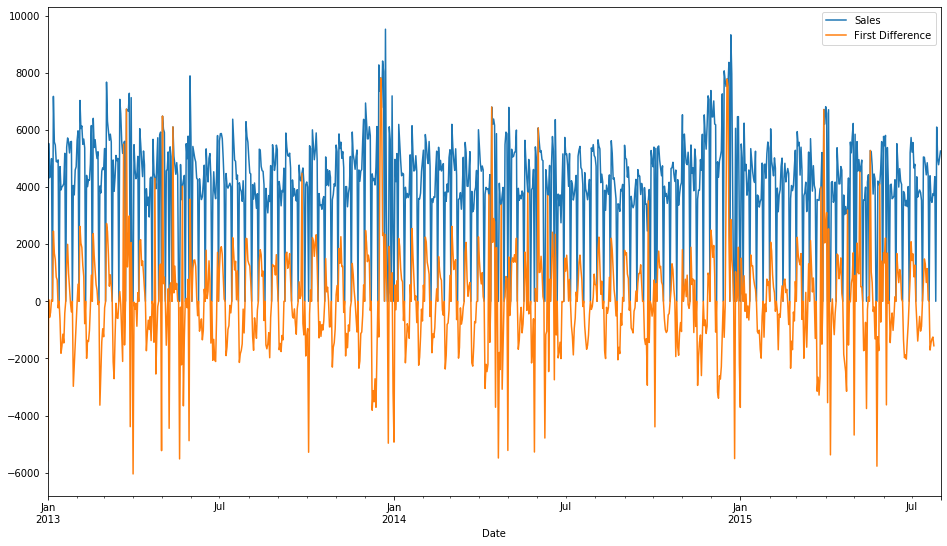

In [58]:
plt.rcParams["figure.figsize"] = [16,9]
fig, ax = plt.subplots()
store1_data['Sales'].plot(legend = True);
diff.plot(legend = True);
ax.legend(['Sales', 'First Difference']);

In [64]:
help(diff)

Help on Series in module pandas.core.series object:

class Series(pandas.core.base.IndexOpsMixin, pandas.core.generic.NDFrame)
 |  Series(data=None, index=None, dtype=None, name=None, copy=False, fastpath=False)
 |  
 |  One-dimensional ndarray with axis labels (including time series).
 |  
 |  Labels need not be unique but must be a hashable type. The object
 |  supports both integer- and label-based indexing and provides a host of
 |  methods for performing operations involving the index. Statistical
 |  methods from ndarray have been overridden to automatically exclude
 |  missing data (currently represented as NaN).
 |  
 |  Operations between Series (+, -, /, *, **) align values based on their
 |  associated index values-- they need not be the same length. The result
 |  index will be the sorted union of the two indexes.
 |  
 |  Parameters
 |  ----------
 |  data : array-like, Iterable, dict, or scalar value
 |      Contains data stored in Series.
 |  
 |      .. versionchanged :

> **Check:** How does differencing help with problems of non-stationarity and autocorrelation in time series data?

<h2><a id="E">Shifting and Lagging Time Series Data</a></h2>

Another common operation on time series data is shifting or lagging values backward and forward in time. This can help us calculate the percentage of change from sample to sample. Pandas has a `.shift()` method for shifting the data in a DataFrame.

Let's take a look at the Rossman data when we apply lagged features. 

In [59]:
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7
2015-07-30,1,4,5020,546,1,1,0,1,2015,7
2015-07-29,1,3,4782,523,1,1,0,1,2015,7
2015-07-28,1,2,5011,560,1,1,0,1,2015,7
2015-07-27,1,1,6102,612,1,1,0,1,2015,7


Let's shift the sales price by one day.

In [62]:
shifted_forward = store1_data.shift(1)
shifted_forward.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,1.0,5.0,5263.0,555.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-29,1.0,4.0,5020.0,546.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-28,1.0,3.0,4782.0,523.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-27,1.0,2.0,5011.0,560.0,1.0,1.0,0,1.0,2015.0,7.0


*Notice that the first row now contains NaN values because there wasn't a previous day's data to shift to that day.*

Next, let's shift the sales prices by five days.

In [63]:
shifted_forward5 = store1_data.shift(5)
shifted_forward5.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-26,1.0,5.0,5263.0,555.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-25,1.0,4.0,5020.0,546.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-24,1.0,3.0,4782.0,523.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-23,1.0,2.0,5011.0,560.0,1.0,1.0,0,1.0,2015.0,7.0


We can also use negative numbers to shift the sales values in the reverse direction.

In [69]:
shifted_backward = store1_data.shift(-1)
shifted_backward.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2015-07-31,1.0,4.0,5020.0,546.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-30,1.0,3.0,4782.0,523.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-29,1.0,2.0,5011.0,560.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-28,1.0,1.0,6102.0,612.0,1.0,1.0,0,1.0,2015.0,7.0
2015-07-27,1.0,7.0,0.0,0.0,0.0,0.0,0,0.0,2015.0,7.0


Lags can be used to calculate the changes in the values you are tracking with your time series data. In this case, we can use Pandas' `.shift()` method to look at the changes in sales. 

Let's create a new column in our Rossman DataFrame that contains the previous day's sales. 

*Note that we added `.copy()` when we filtered out the store 1 sales earlier. If we didn't explictly tell Pandas that `store1_data` is a copy (instead of a view), we would receive a `SettingCopyWarning`. Here is a useful [video](https://www.youtube.com/watch?v=4R4WsDJ-KVc) that helps explain how to avoid SettingCopyWithWarning errors in Pandas.*

In [70]:
store1_data['Prev Day Sales'] = store1_data['Sales'].shift(-1)
store1_data.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Prev Day Sales,Sales Change
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,5020.0,243.0
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,4782.0,238.0
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,5011.0,-229.0
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,6102.0,-1091.0
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,0.0,6102.0
2015-07-26,1,7,0,0,0,0,0,0,2015,7,4364.0,-4364.0
2015-07-25,1,6,4364,500,1,0,0,0,2015,7,3706.0,658.0
2015-07-24,1,5,3706,459,1,0,0,0,2015,7,3769.0,-63.0
2015-07-23,1,4,3769,503,1,0,0,0,2015,7,3464.0,305.0


Using our new column, it's simple to calculate the one-day change in sales at Store 1. Let's create a new column for this value in our DataFrame as well.

In [66]:
store1_data['Sales Change'] = store1_data['Sales'] - store1_data['Prev Day Sales']
store1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Prev Day Sales,Sales Change
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,5020.0,243.0
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,4782.0,238.0
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,5011.0,-229.0
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,6102.0,-1091.0
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,0.0,6102.0


# Recap

* Trends are long-term changes in data. We have to sort through the noise of a time series to identify trends.
* We can resample the data to look at simple aggregates and identify patterns.
* Rolling statistics give us a local statistic of an average in time, smoothing out random fluctuations and removing outliers.

<h2><a id="F">Independent Practice</a></h2>

**Instructor Note:** These are optional and can be assigned as student practice questions outside of class.

### 1) Load the Unemployment data set. Perform any necessary cleaning and preprocess the data by creating a `datetime` index.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [72]:
unemp = pd.read_csv('./unemployment.csv')

In [76]:
unemp.head()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%
2,1948Q3,3.767%
3,1948Q4,3.833%
4,1949Q1,4.667%


In [77]:
unemp.columns = ['year_quarter', 'unemployment_rate']
unemp['unemployment_rate'] = unemp['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
unemp.dropna(inplace=True)

In [78]:
# This is quarterly data, so converting to datetime is a bit complicated. .dt.to_period('Q') will help us represent the string as a datetime object.
unemp['date'] = pd.to_datetime(unemp.year_quarter).dt.to_period('Q')
unemp.set_index('date', inplace=True)
unemp.head()

,year_quarter,unemployment_rate
date,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


### 2) Plot the unemployment rate.

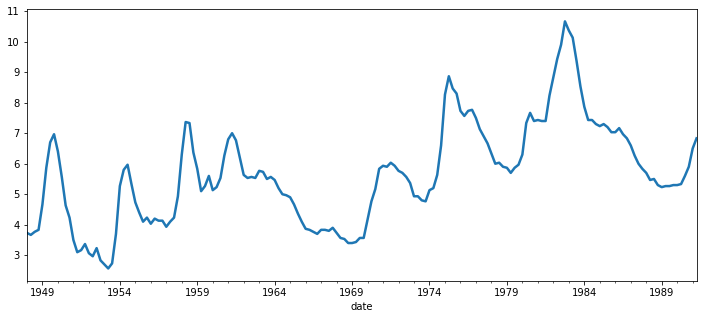

In [84]:
unemp['unemployment_rate'].plot(lw=2.5, figsize=(12,5));

### 3) Calculate the rolling mean of years with `window=3 `, without centering, and plot both the unemployment rates and the rolling mean data.

In [81]:
yearly = unemp['unemployment_rate'].resample('A').mean().rolling(window=3, center=False).mean()

In [82]:
yearly

date
1948         NaN
1949         NaN
1950    5.002833
1951    4.847333
1952    3.838917
1953    3.077833
1954    3.847250
1955    4.294417
1956    4.694333
1957    4.263667
1958    5.088750
1959    5.530500
1960    5.944417
1961    5.894417
1962    5.933250
1963    5.966667
1964    5.455583
1965    5.102917
1966    4.486250
1967    4.047250
1968    3.730500
1969    3.630500
1970    4.011167
1971    4.808333
1972    5.511167
1973    5.469417
1974    5.366667
1975    6.325000
1976    7.272250
1977    7.741750
1978    6.938833
1979    6.322250
1980    6.363917
1981    6.880583
1982    8.166583
1983    8.974917
1984    8.938833
1985    8.099917
1986    7.233250
1987    6.788833
1988    6.222250
1989    5.644500
1990    5.430583
1991    5.822167
Freq: A-DEC, Name: unemployment_rate, dtype: float64

In [85]:
# Extract the dates from the index as timestamps.
date_ticks_orig = unemp.index.to_timestamp()
date_ticks_roll = yearly.index.to_timestamp()

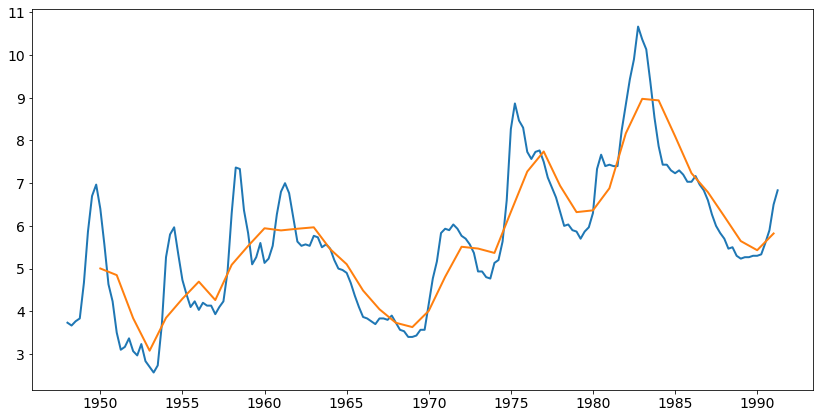

In [86]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, unemp.unemployment_rate.values,lw=2)
plt.plot(date_ticks_roll, yearly.values, lw=2)

plt.tick_params(labelsize=14)

### 4) Calculate the rolling median with `window=5` and `window=15`. Plot both together with the original data.

In [87]:
uroll_w5 = unemp.unemployment_rate.rolling(window=5).median()
uroll_w15 = unemp.unemployment_rate.rolling(window=15).median()

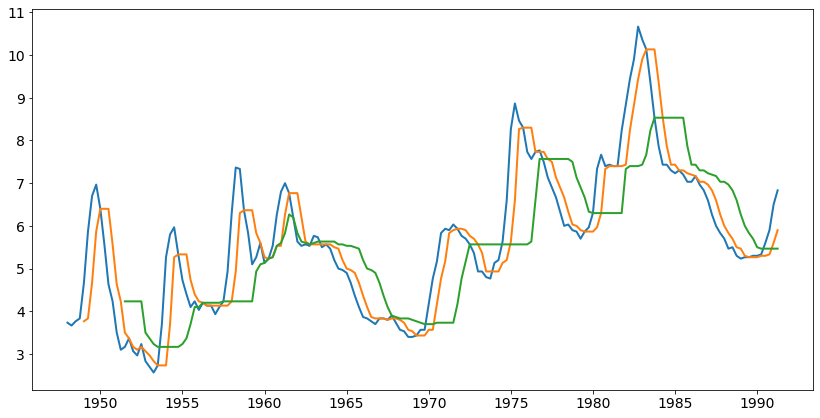

In [88]:
plt.figure(figsize=(14,7))

plt.plot(date_ticks_orig, unemp.unemployment_rate.values,lw=2)
plt.plot(date_ticks_orig, uroll_w5, lw=2)
plt.plot(date_ticks_orig, uroll_w15, lw=2)

plt.tick_params(labelsize=14)

### 5) Calculate and plot the expanding mean. Resample by quarter. Plot the rolling mean and the expanding mean together.

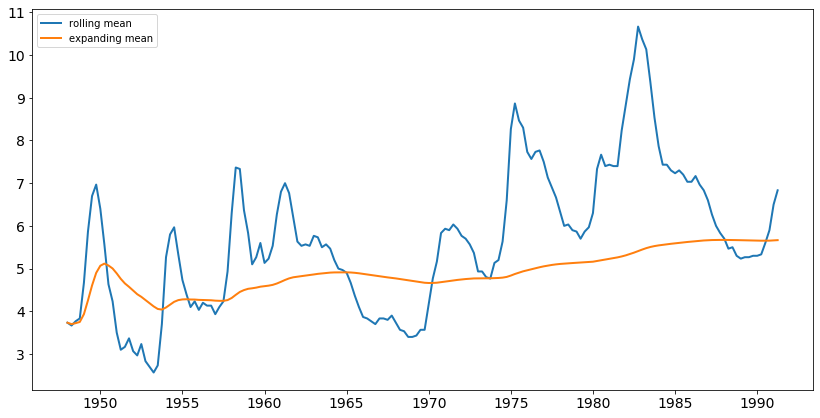

In [89]:
date_ticks = unemp.index.to_timestamp()

rolling_mean = unemp.unemployment_rate.resample('Q').sum().rolling(window=1, center=False).mean()
expanding_mean = unemp.unemployment_rate.resample('Q').sum().expanding().mean()

plt.figure(figsize=(14,7))

plt.plot(date_ticks, rolling_mean, alpha=1, lw=2, label='rolling mean')
plt.plot(date_ticks, expanding_mean, alpha=1, lw=2, label='expanding mean')

plt.legend(loc='upper left')

plt.tick_params(labelsize=14)

### 6) Calculate and plot the exponentially weighted sum along with the rolling sum.

In [90]:
rolling_mean = unemp.unemployment_rate.resample('Q').sum().rolling(window=2, center=True).mean()
exp_weighted_mean = unemp.unemployment_rate.resample('Q').sum().ewm(span=10).mean()

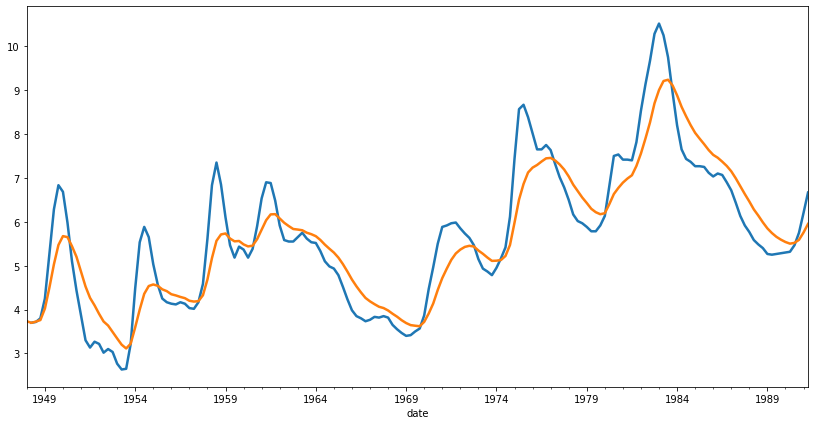

In [92]:
ax = rolling_mean.plot(lw=2.5, figsize=(14,7));
exp_weighted_mean.plot(ax=ax, lw=2.5);

### 7) Difference the unemployment rate and plot.

In [93]:
unemp['unemp_diff'] = unemp['unemployment_rate'].diff()

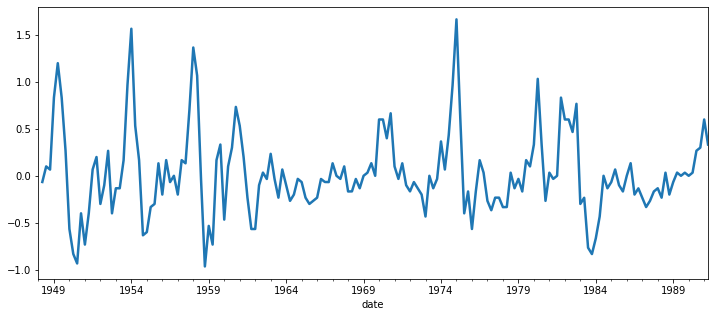

In [94]:
unemp['unemp_diff'].plot(lw=2.5, figsize=(12,5));